347119616/347116733 [==============================] - 3s 0us/step


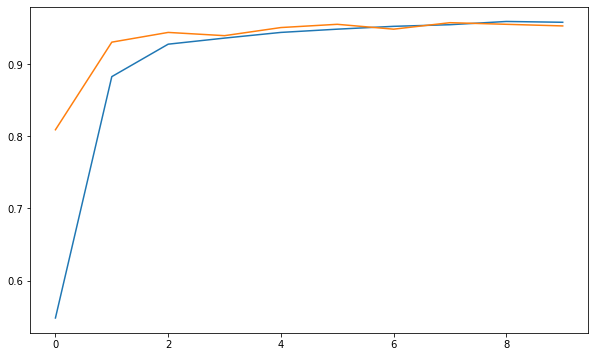

In [1]:
#Import required library
import tensorflow as tf
import pathlib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import io
import matplotlib.pyplot as plt
#Get training File
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv'
data_dir = tf.keras.utils.get_file('bbc-text-new.csv', origin=dataset_url )
data_dir = pathlib.Path(data_dir)

#Read file
sentences = []
labels = []
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
              "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
              "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
              "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's",
              "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my",
              "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same",
              "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them",
              "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through",
              "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when",
              "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll",
              "you're", "you've", "your", "yours", "yourself", "yourselves"]
with open(data_dir, 'r') as file:
    i = 0
    for line in file:
        if i == 0:
            i = i + 1
        else:
            line = line.replace('\n', '')
            labels.append(line.split(',')[0])
            arr = line.split(',')[1].split()
            new_arr = [word for word in arr if not word in stopwords]
            sentence = ' '.join(word for word in new_arr)
            sentences.append(sentence)
#Define label dictionary
i = 0
label_dict = {}
for lbl in set(labels):
    label_dict[lbl] = i
    i = i + 1
new_labels = []
for lbl in labels:
    new_labels.append(label_dict[lbl])
#Define Training Parameter
oov_token = '<oov>'
vocab_size = 10000
max_len = 200
padding = 'post'
truncating = 'post'
training_size = 0.8
emb_dim = 100
#Split Train and Test Data
split_size = int(len(sentences)*training_size)
train_sentences = sentences[0:split_size]
train_labels = new_labels[0:split_size]
test_sentences = sentences[split_size:]
test_labels = new_labels[split_size:]
#Define Tokenizer
tokenizer = Tokenizer(oov_token=oov_token, num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)
#Method to preprocess data
def data_preprocessing(sentences, labels):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating=truncating, padding=padding)
    X = np.array(padded_sequences)
    y = tf.keras.utils.to_categorical(labels, len(label_dict.keys()))
    return X, y
#Get training data
X_train, y_train = data_preprocessing(train_sentences, train_labels)
X_test, y_test = data_preprocessing(test_sentences, test_labels)
#Get Pretrained Embedding
dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
data_dir = tf.keras.utils.get_file('glove.6B.100d.txt', origin=dataset_url)
data_dir = pathlib.Path(data_dir)
glove_word_emb = {}
with open(data_dir, 'r') as file:
    for line in file:
        line = line.replace('\n', '')
        word = line.split(' ')[0]
        emb = [float(val) for val in line.split(' ')[1:]]
        glove_word_emb[word] = emb
#Define embedding metrix for model
embedding_metrix = np.zeros((vocab_size+1, emb_dim))
for key, i in tokenizer.word_index.items():
    embedding_vector = glove_word_emb.get(key)
    if embedding_vector is not None:
        embedding_metrix[i] = embedding_vector
    if i == 10000:
        break
#Define Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=emb_dim, input_length=max_len, weights=[embedding_metrix], trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(len(label_dict.keys()), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])